## Load necessary libraries

In [1]:
import pickle
from sklearn.preprocessing import OneHotEncoder
import numpy as np
embeddings, labels, seq_ids = pickle.load(open("/data/xhorvat9/ltr_bert/NewClassifiers/Lineage/BERT/LTRBERT_superfamily_classifier_embeddings.b_average", "rb"))

In [2]:
OHE = OneHotEncoder()
l_ohe = OHE.fit_transform(np.array(labels).reshape(-1,1))

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(embeddings, labels, random_state=42, test_size=0.1)

# Train top classification layer for the 10 lineages

In [6]:
import tensorflow as tf
import keras
import numpy as np
nn = keras.models.Sequential()
nn.add(keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(768,1)))
nn.add(keras.layers.MaxPooling1D(pool_size=2))
nn.add(keras.layers.Flatten())
nn.add(keras.layers.Dense(units=128, activation='relu'))
nn.add(keras.layers.Dropout(0.5)) 
nn.add(keras.layers.Dense(units=15, activation='softmax'))

nn.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.AdamW(), metrics=['sparse_categorical_accuracy'], weighted_metrics=["sparse_categorical_accuracy"])

nn.fit(X_train, np.array(y_train), epochs=15, batch_size=16, validation_data=(X_val, np.array(y_val)), callbacks=[keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/15
 869/2680 [========>.....................] - ETA: 5s - loss: 1.1632 - sparse_categorical_accuracy: 0.6695 - weighted_sparse_categorical_accuracy: 0.6695

2680/2680 [==============================] - 10s 3ms/step - loss: 1.0178 - sparse_categorical_accuracy: 0.7150 - weighted_sparse_categorical_accuracy: 0.7150 - val_loss: 0.7815 - val_sparse_categorical_accuracy: 0.7853 - val_weighted_sparse_categorical_accuracy: 0.7853
Epoch 2/15
2680/2680 [==============================] - 8s 3ms/step - loss: 0.8569 - sparse_categorical_accuracy: 0.7564 - weighted_sparse_categorical_accuracy: 0.7564 - val_loss: 0.7647 - val_sparse_categorical_accuracy: 0.7848 - val_weighted_sparse_categorical_accuracy: 0.7848
Epoch 3/15
2680/2680 [==============================] - 8s 3ms/step - loss: 0.7985 - sparse_categorical_accuracy: 0.7732 - weighted_sparse_categorical_accuracy: 0.7732 - val_loss: 0.7219 - val_sparse_categorical_accuracy: 0.7983 - val_weighted_sparse_categorical_accuracy: 0.7983
Epoch 4/15
2680/2680 [==============================] - 7s 3ms/step - loss: 0.7520 - sparse_categorical_accuracy: 0.7847 - weighted_sparse_categorical_accuracy: 0.7847 - 

In [5]:
nn.save('CNN_BERT_pool_model')

INFO:tensorflow:Assets written to: CNN_BERT_pool_model/assets


INFO:tensorflow:Assets written to: CNN_BERT_pool_model/assets


In [88]:
import tensorflow as tf
import keras
import numpy as np
nn = keras.models.Sequential()
nn.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
nn.add(keras.layers.MaxPooling1D(pool_size=2))
nn.add(keras.layers.Flatten())
#nn.add(keras.layers.Dense(units=32, activation='relu'))
nn.add(keras.layers.Dense(units=10, activation='softmax'))

nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["categorical_accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])#, balanced_accuracy_score])

nn.fit(X_train, y_train.todense(), epochs=4, batch_size=32, validation_data=(X_val,y_val.todense()))

Epoch 1/4
1038/1038 [==============================] - 5s 5ms/step - loss: 0.5307 - categorical_accuracy: 0.8460 - precision_2: 0.9081 - recall_2: 0.7980 - val_loss: 0.4952 - val_categorical_accuracy: 0.8563 - val_precision_2: 0.9101 - val_recall_2: 0.8188
Epoch 2/4
1038/1038 [==============================] - 5s 4ms/step - loss: 0.4450 - categorical_accuracy: 0.8712 - precision_2: 0.9200 - recall_2: 0.8351 - val_loss: 0.4733 - val_categorical_accuracy: 0.8638 - val_precision_2: 0.9228 - val_recall_2: 0.8168
Epoch 3/4
1038/1038 [==============================] - 5s 4ms/step - loss: 0.4035 - categorical_accuracy: 0.8811 - precision_2: 0.9244 - recall_2: 0.8477 - val_loss: 0.4977 - val_categorical_accuracy: 0.8564 - val_precision_2: 0.9108 - val_recall_2: 0.8200
Epoch 4/4
1038/1038 [==============================] - 5s 4ms/step - loss: 0.3668 - categorical_accuracy: 0.8917 - precision_2: 0.9306 - recall_2: 0.8612 - val_loss: 0.4771 - val_categorical_accuracy: 0.8631 - val_precision_2: 0.

In [89]:
nn.evaluate(X_test, np.array(y_test.todense()))

  1/260 [..............................] - ETA: 9s - loss: 0.5340 - categorical_accuracy: 0.8125 - precision_2: 0.8929 - recall_2: 0.7812

260/260 [==============================] - 1s 3ms/step - loss: 0.4771 - categorical_accuracy: 0.8631 - precision_2: 0.9053 - recall_2: 0.8358


[0.47712957859039307,
 0.8631490468978882,
 0.9052714109420776,
 0.8358029127120972]

In [70]:
type(nn.predict(X_test))

260/260 [==============================] - 0s 1ms/step


numpy.ndarray

In [114]:
val_results = tf.argmax(nn.predict(X_val), axis=1).numpy()

  1/260 [..............................] - ETA: 8s

260/260 [==============================] - 1s 2ms/step


In [90]:
from sklearn.preprocessing import LabelEncoder
import Bio.SeqIO as SeqIO
import pandas as pd
max_len=512
records  = [rec for rec in SeqIO.parse("/var/tmp/xhorvat9/ltr_bert/FASTA_files/train_LTRs.fasta", "fasta") if len(rec.seq) >= max_len and len(rec.seq) > 0]

data = pd.DataFrame({'sequence':[str(rec.seq) for rec in records], 'label':[rec.description.split(" ")[4] for rec in records], "seq_id":[rec.id for rec in records]})
data = data[data["label"].isin(["Tekay", "Reina", "CRM", "Ivana", "Athila", "Tork", "Retand", "Ale", "SIRE", "Angela"])]
le = LabelEncoder()
labels = list(le.fit_transform(data["label"]))

# See lineage distribution

In [91]:
import seaborn as sns
records  = [rec for rec in SeqIO.parse("/var/tmp/xhorvat9/ltr_bert/FASTA_files/train_LTRs.fasta", "fasta") if len(rec.seq) >= max_len and len(rec.seq) > 0]

data = pd.DataFrame({'sequence':[str(rec.seq) for rec in records], 'label':[rec.description.split(" ")[4] for rec in records], "seq_id":[rec.id for rec in records]})
g = sns.histplot(data["label"])
g.set_xticklabels(g.get_xticklabels(), rotation=90);

/tmp/ipykernel_1232369/2141329484.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90);


# Visualize validation results

In [116]:
from sklearn.metrics import classification_report
pd.DataFrame(classification_report(le.inverse_transform(np.asarray(y_val.argmax(axis=1).reshape(1,-1))[0]), le.inverse_transform(val_results), output_dict=True)).drop(columns=['macro avg', 'weighted avg'])

Ale      Angela       Athila          CRM      Ivana  \
precision   0.809524    0.864173     0.737295     0.945962   0.763158   
recall      0.177083    0.766143     0.856000     0.889617   0.432836   
f1-score    0.290598    0.812211     0.792226     0.916925   0.552381   
support    96.000000  573.000000  1000.000000  1830.000000  67.000000   

               Reina      Retand        SIRE        Tekay        Tork  \
precision   0.811321    0.900336    0.745006     0.887155    0.903010   
recall      0.573333    0.907449    0.846462     0.919173    0.739726   
f1-score    0.671875    0.903879    0.792500     0.902880    0.813253   
support    75.000000  886.000000  749.000000  2660.000000  365.000000   

           accuracy  
precision  0.863149  
recall     0.863149  
f1-score   0.863149  
support    0.863149

Text(0.5, 1.0, 'BERT Lineage Classifier Validation Results')

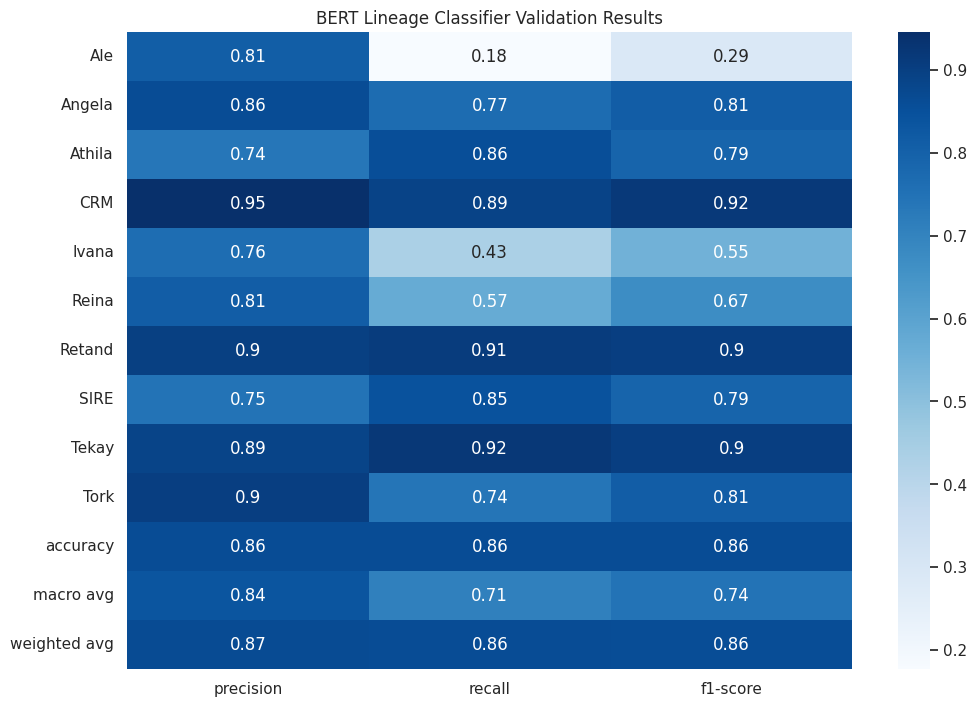

In [131]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
sns.set(rc={'figure.figsize':(11.7,8.27)})
#(results == y_test.argmax(axis=1).reshape(1,-1)).astype(int).sum()/len(results)
cr = pd.DataFrame(classification_report(le.inverse_transform(np.asarray(y_val.argmax(axis=1).reshape(1,-1))[0]), le.inverse_transform(val_results), output_dict=True)).iloc[:-1, :].T
g = sns.heatmap(cr, annot=True, cmap='Blues')
g.set_title('BERT Lineage Classifier Validation Results')


Text(0.5, 1.0, 'BERT Lineage Classifier Validation CM')

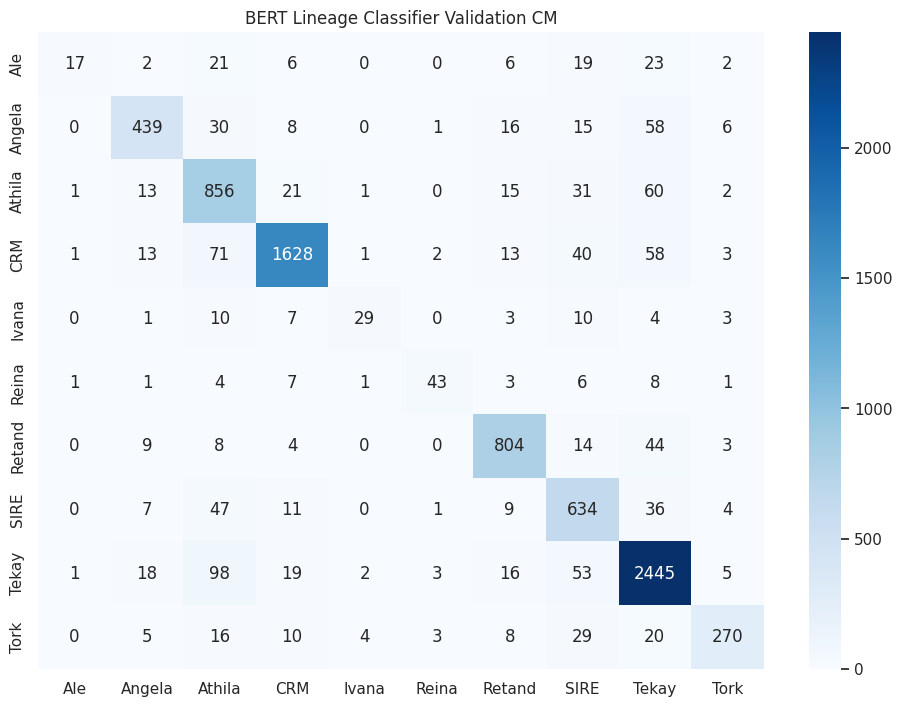

In [130]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
g = sns.heatmap(confusion_matrix(le.inverse_transform(np.asarray(y_val.argmax(axis=1).reshape(1,-1))[0]), le.inverse_transform(val_results)), annot=True, fmt='g', cmap="Blues")
g.set_xticklabels(le.inverse_transform([i for i in range(len(le.classes_))]))
g.set_yticklabels(le.inverse_transform([i for i in range(len(le.classes_))]))
g.set_title('BERT Lineage Classifier Validation CM')

# Visualize test results

In [122]:
test_embeddings, test_labels, seq_ids = pickle.load(open("/var/tmp/xhorvat9/ltr_bert/NewClassifiers/Lineage/BERT/LTRBERT_superfamily_classifier_embeddings_TEST.b_average", "rb"))
test_results = tf.argmax(nn.predict(test_embeddings), axis=1).numpy()

328/328 [==============================] - 1s 2ms/step


Text(0.5, 1.0, 'BERT Lineage Classifier Test Results')

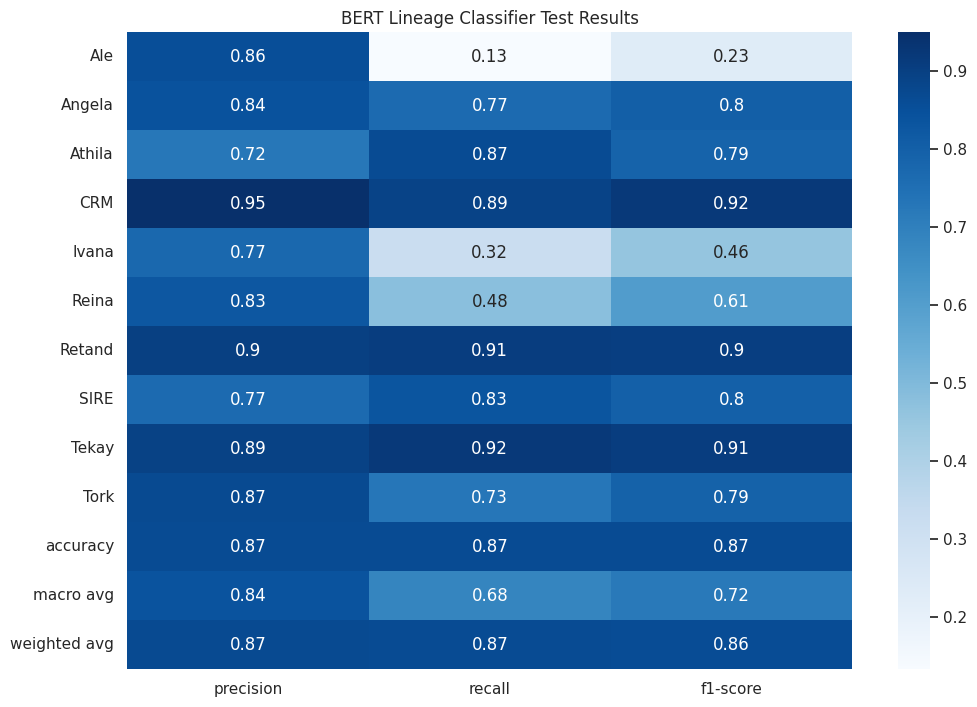

In [129]:

l_ohe = OHE.fit_transform(np.array(test_labels).reshape(-1,1))
#(results == y_test.argmax(axis=1).reshape(1,-1)).astype(int).sum()/len(results)
cr = pd.DataFrame(classification_report(le.inverse_transform(np.asarray(l_ohe.argmax(axis=1).reshape(1,-1))[0]), le.inverse_transform(test_results), output_dict=True)).iloc[:-1, :].T
g = sns.heatmap(cr, annot=True, cmap='Blues')
g.set_title('BERT Lineage Classifier Test Results')


Text(0.5, 1.0, 'BERT Lineage Classifier Test CM')

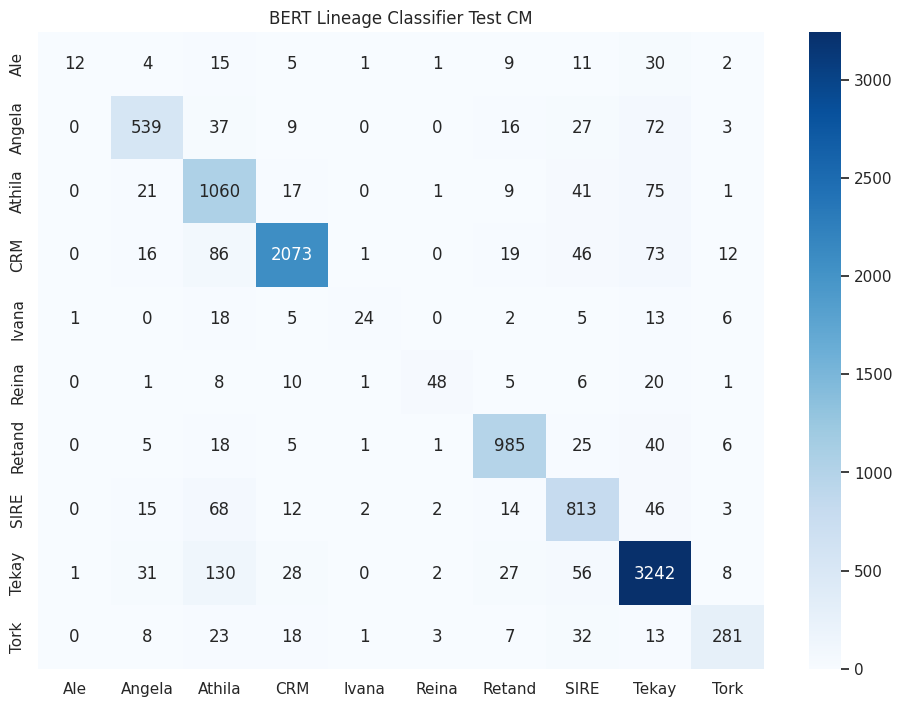

In [128]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
g = sns.heatmap(confusion_matrix(le.inverse_transform(np.asarray(l_ohe.argmax(axis=1).reshape(1,-1))[0]), le.inverse_transform(results)), annot=True, fmt='g', cmap="Blues")
g.set_xticklabels(le.inverse_transform([i for i in range(len(le.classes_))]))
g.set_yticklabels(le.inverse_transform([i for i in range(len(le.classes_))]))
g.set_title('BERT Lineage Classifier Test CM')

# Plot BERT embeddings

In [132]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

# PCA
n_components = 2  # Number of components (2 for 2D visualization)
embeddings_PCA = PCA(n_components=n_components).fit_transform(test_embeddings)

# SVD
n_components = 2  # Number of components (2 for 2D visualization)
embeddings_SVD = TruncatedSVD(n_components=n_components).fit_transform(test_embeddings)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, metric="cosine").fit_transform(test_embeddings)


[Text(0.5, 1.0, 'SVD transformed embeddings')]

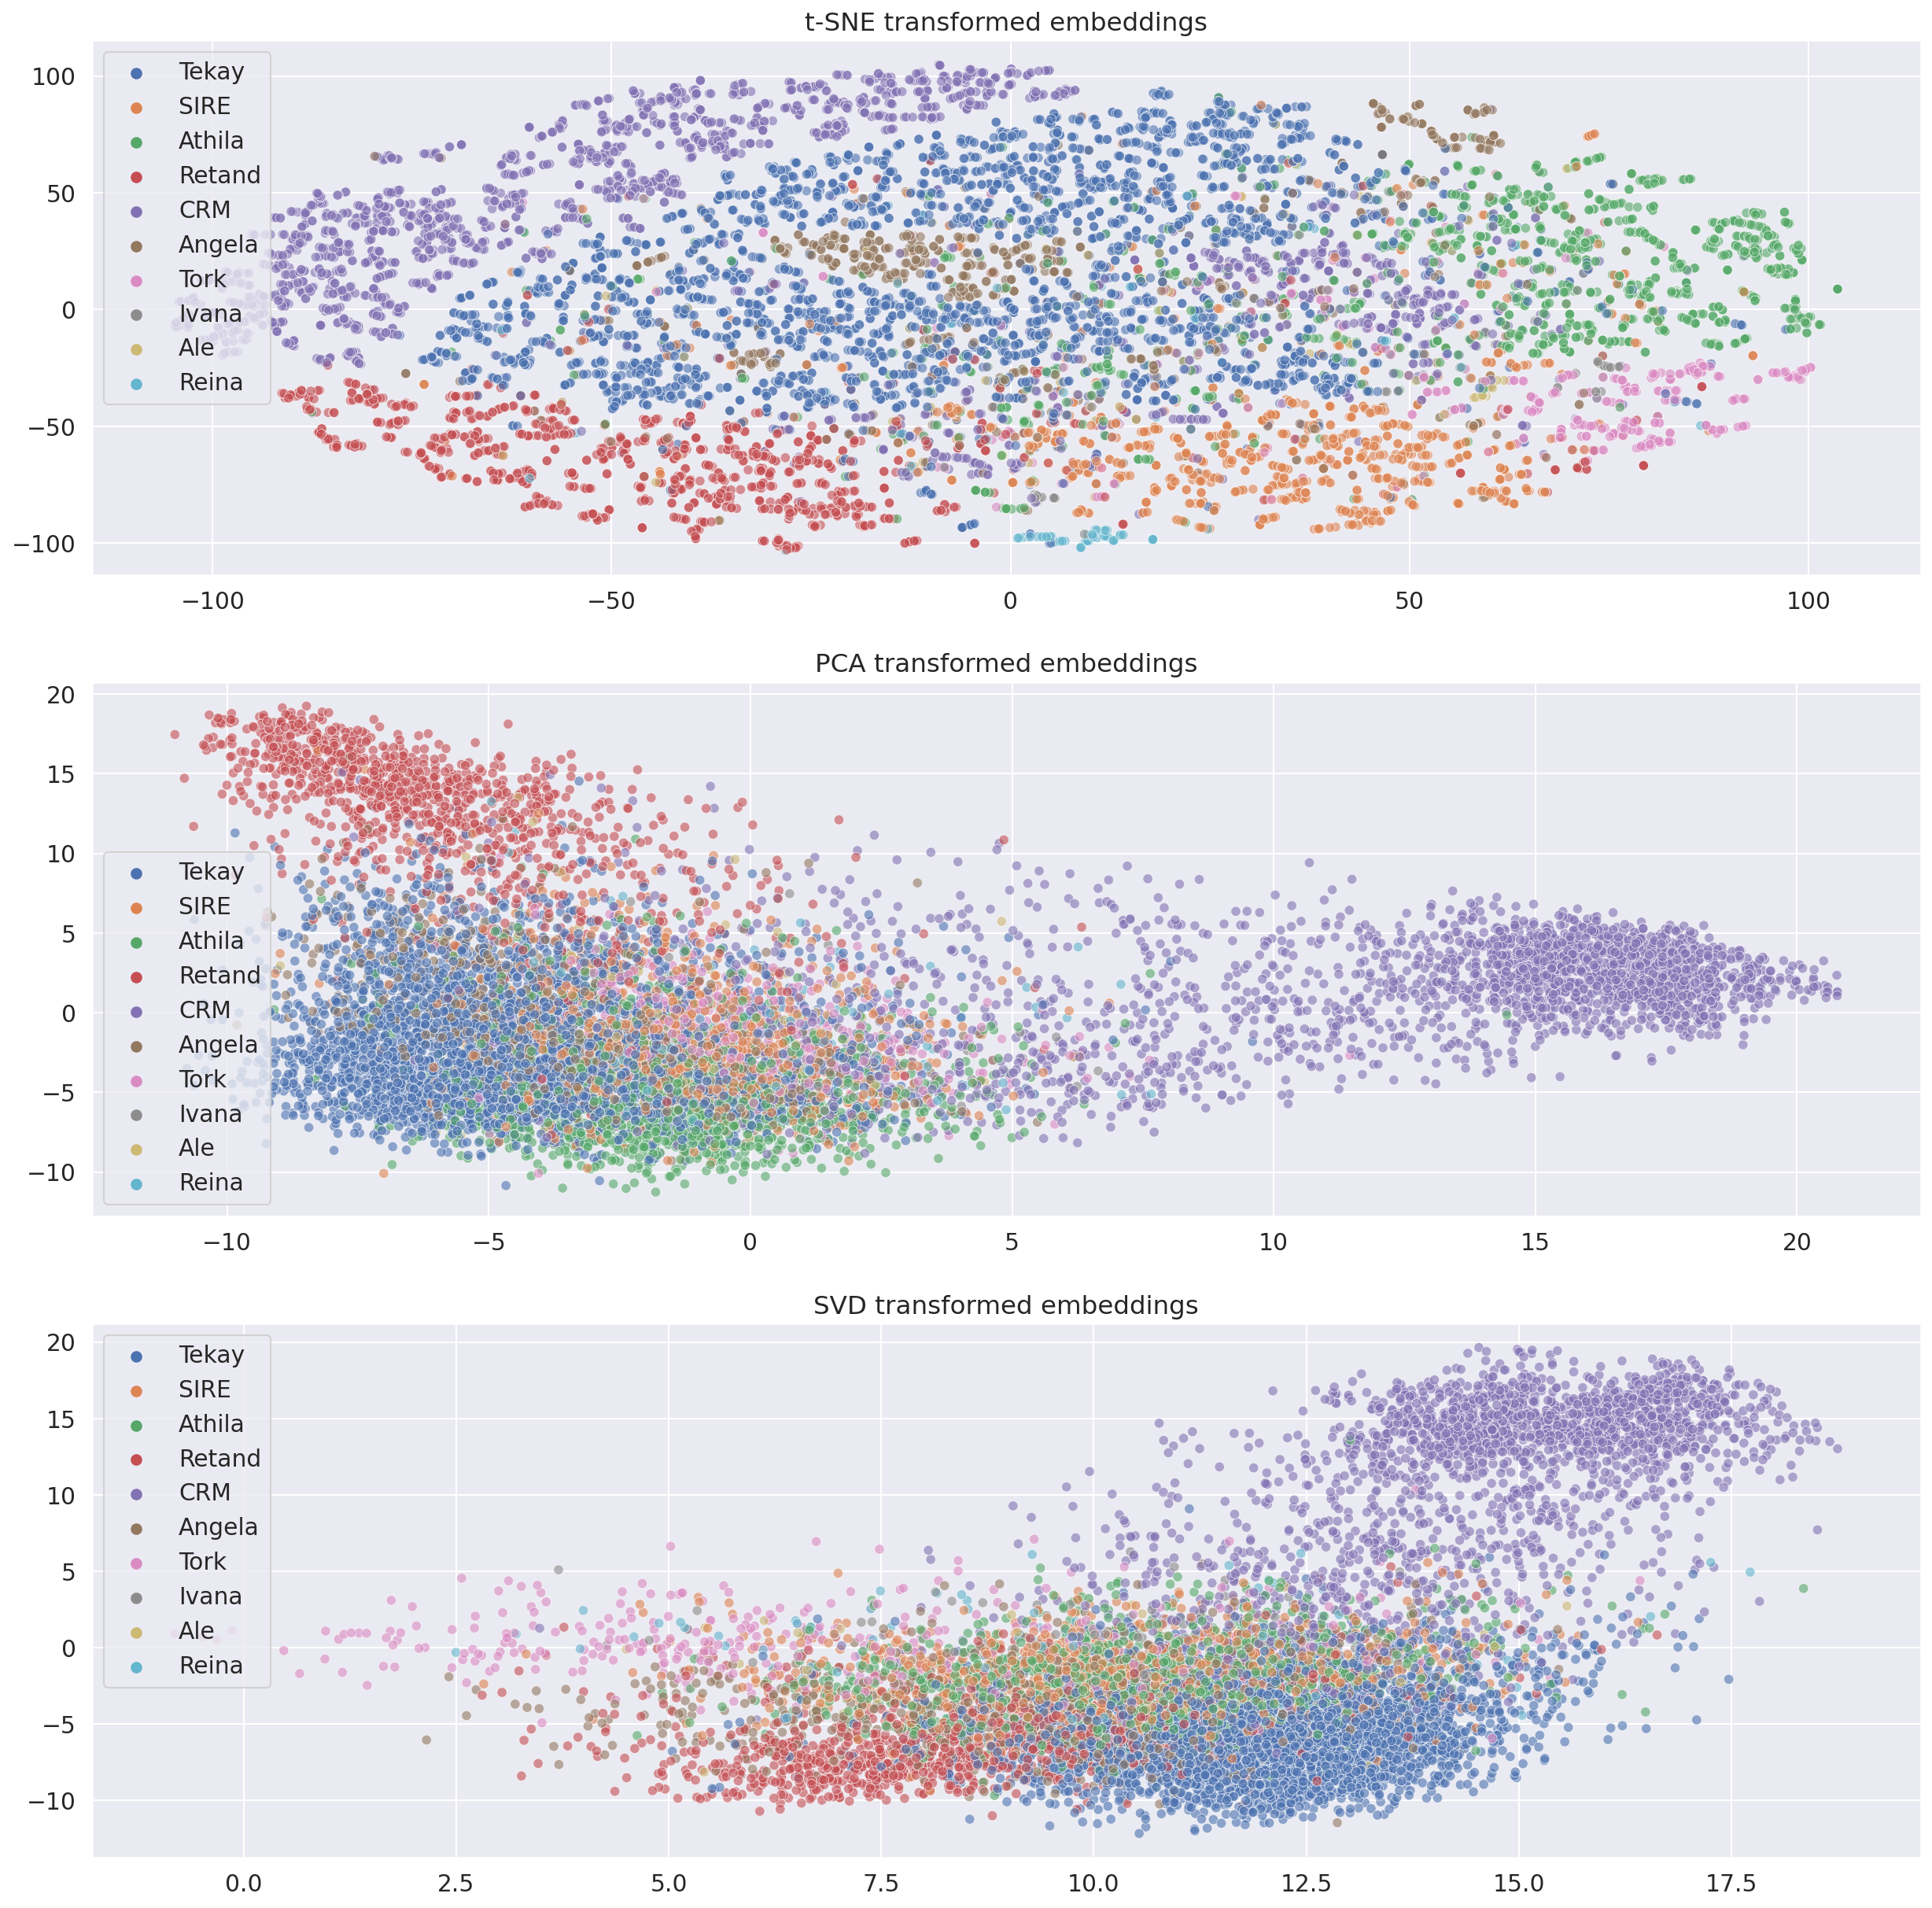

<Figure size 1000x600 with 0 Axes>

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axs = plt.subplots(3,1,figsize=(20,20), dpi=150)

plt.figure(figsize=(10, 6))
sns.set(font_scale=1.3)  # crazy big
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], marker='o',hue=le.inverse_transform(test_labels), ax=axs[0], alpha=0.6).set(title='t-SNE transformed embeddings')
sns.scatterplot(x=embeddings_PCA[:, 0], y=embeddings_PCA[:, 1], marker='o',hue=le.inverse_transform(test_labels), ax=axs[1], alpha=0.6).set(title='PCA transformed embeddings')
sns.scatterplot(x=embeddings_SVD[:, 0], y=embeddings_SVD[:, 1], marker='o',hue=le.inverse_transform(test_labels), ax=axs[2], alpha=0.6).set(title='SVD transformed embeddings')

In [172]:
sizes = np.array(test_labels) == test_results

In [171]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, test_results)

0.865300285986654

In [168]:
test_results

array([8, 7, 2, ..., 7, 7, 8])

In [197]:
result_array = np.where(sizes, "Correct", "Incorrect")
result_alpha = np.where(sizes, 0.15, 0.9)

[Text(0.5, 1.0, 't-SNE transformed embeddings')]

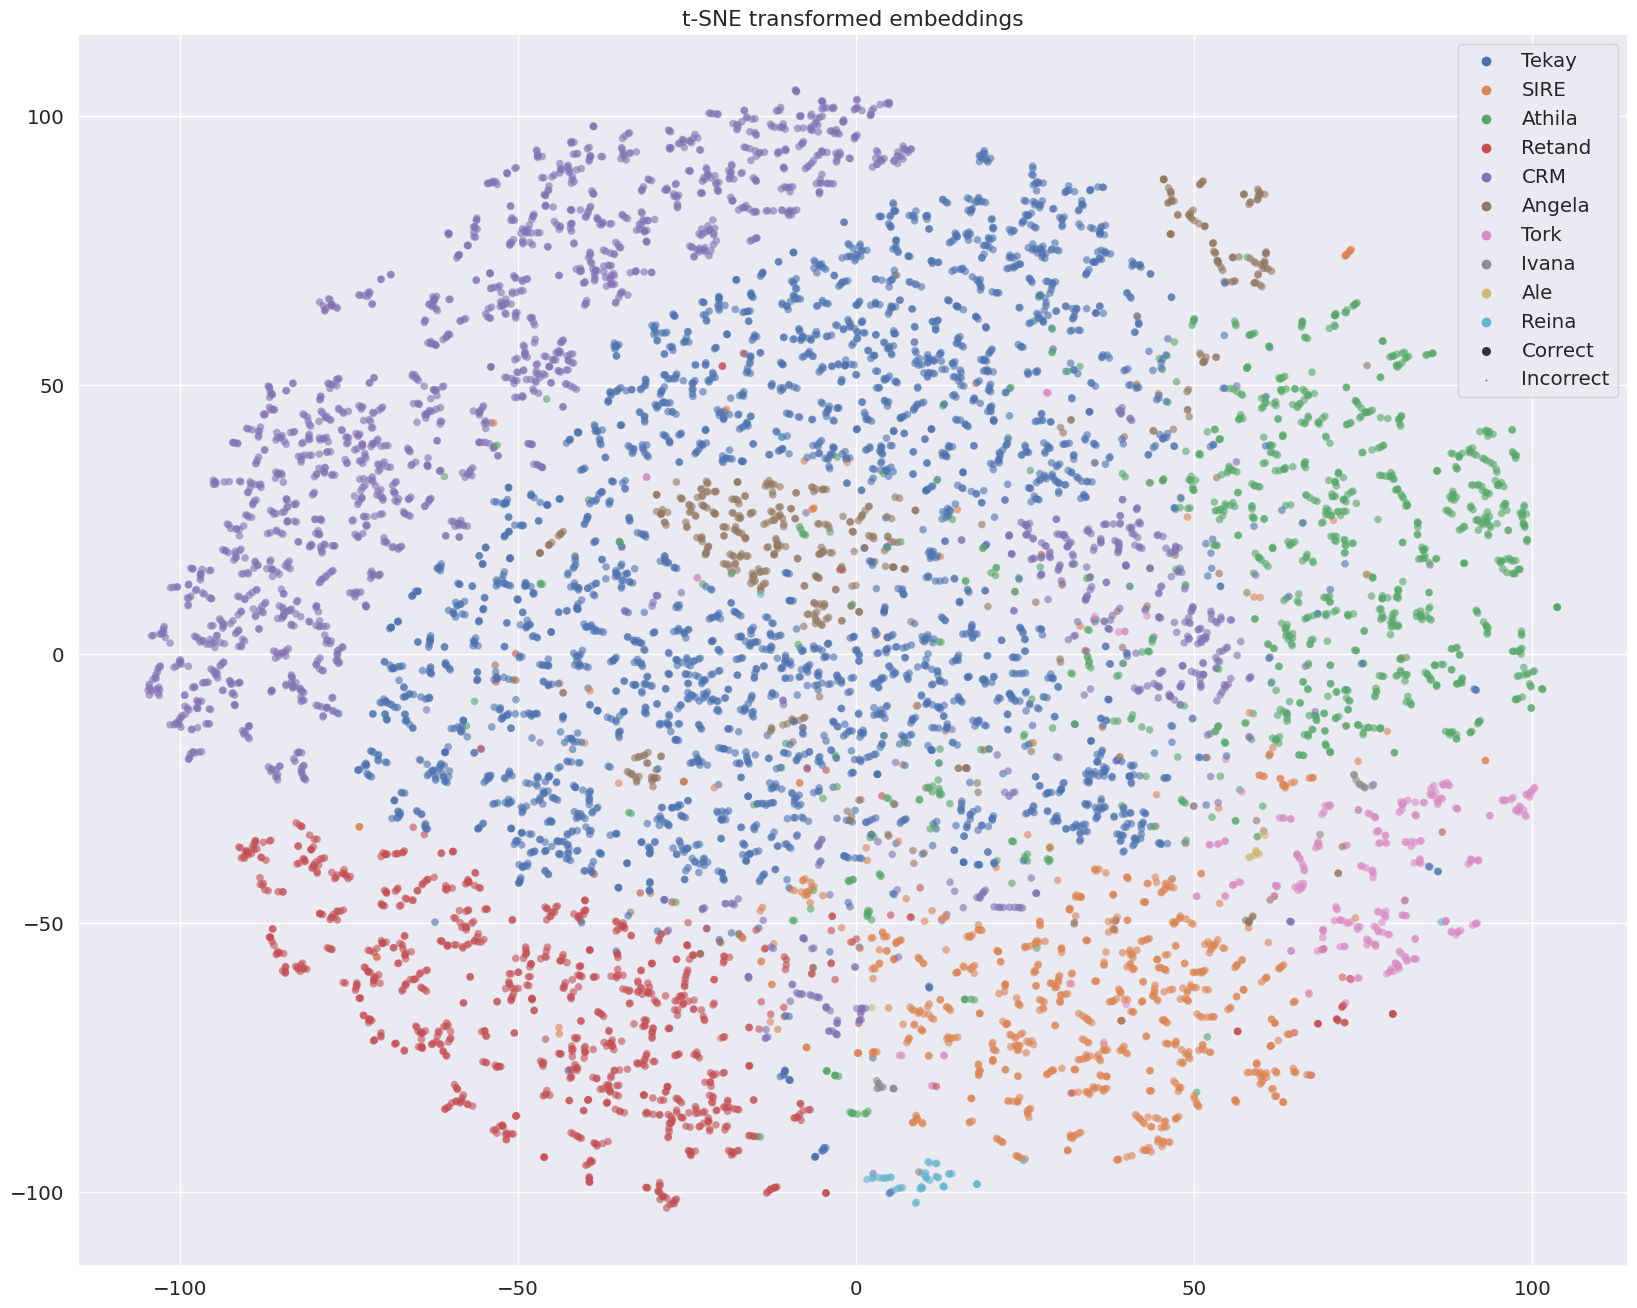

In [202]:

plt.figure(figsize=(20, 16))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], marker='o',hue=le.inverse_transform(test_labels), alpha=0.6, size=result_array, sizes=(0.1, 30)).set(title='t-SNE transformed embeddings ONLY CORRECT')

[Text(0.5, 1.0, 't-SNE transformed embeddings INCORRECT ENHANCED')]

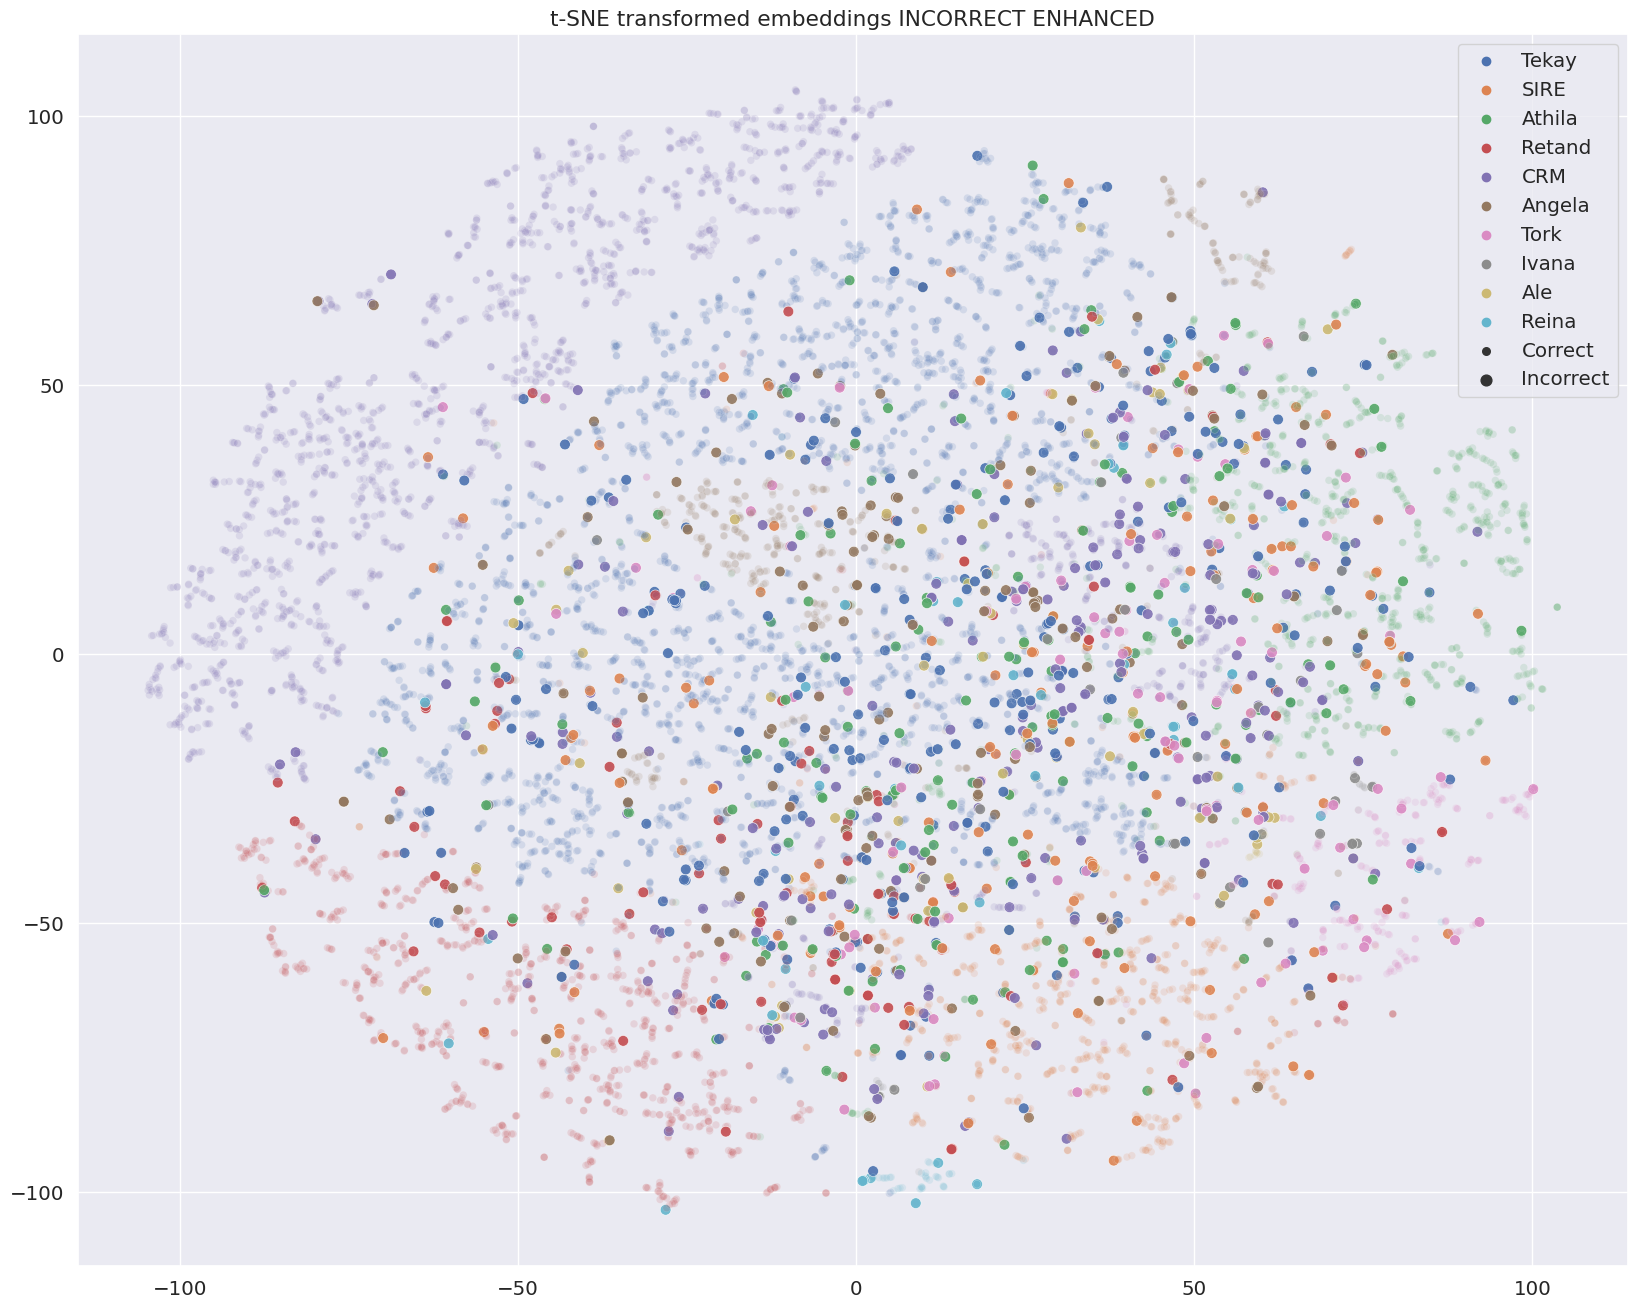

In [204]:

plt.figure(figsize=(20, 16))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], marker='o',hue=le.inverse_transform(test_labels), alpha=result_alpha, size=result_array, sizes=(60, 30)).set(title='t-SNE transformed embeddings INCORRECT ENHANCED')

In [10]:
pred = [1 if x > 0.5 else 0 for x in predictions]

In [22]:
import pandas as pd
import Bio.SeqIO as SeqIO
max_len=512
seq_ids = [rec.id for rec in SeqIO.parse("/var/tmp/xhorvat9/ltr_bert/FASTA_files/test_LTRs.fasta", "fasta") if len(rec.seq) >= max_len and len(rec.seq) > 0 and rec.description.split()[3] != "NAN"]
pd.DataFrame({"ID": seq_ids, "actual": test_labels, "pred": pred}).to_csv("test_predictions.csv", index=False)

In [18]:
import numpy as np
(np.array(test_labels) == pred).astype(int).sum()/len(test_labels)

0.8787396562698918

[Text(0, 0, 'F1:\n0.82'), Text(0, 0, 'F1:\n0.84'), Text(0, 0, 'F1:\n0.90')]

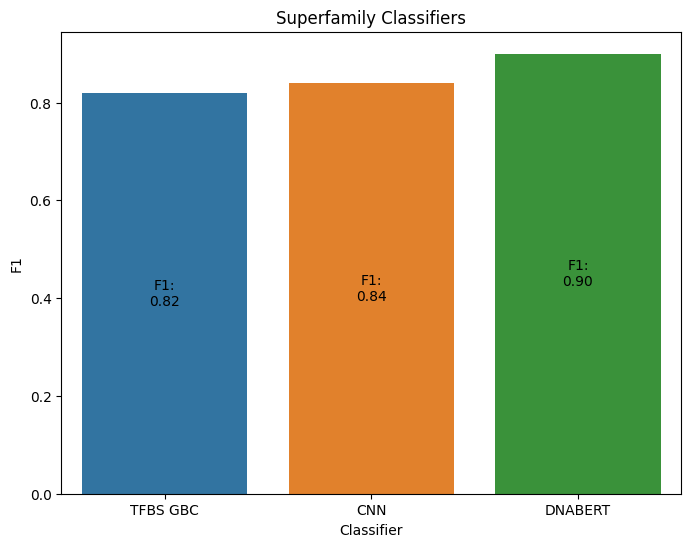

In [34]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=(8, 6),dpi=100)

Superfam = pd.DataFrame({"F1": [0.82,0.84,0.9], "Classifier": ["TFBS GBC","CNN","DNABERT"]})
g = sns.barplot(x="Classifier", y="F1", data=Superfam, ax=ax)
g.set_title("Superfamily Classifiers")
ax.bar_label(ax.containers[-1], fmt='F1:\n%.2f', label_type='center')

[Text(0, 0, 'F1:\n0.89'), Text(0, 0, 'F1:\n0.75'), Text(0, 0, 'F1:\n0.89')]

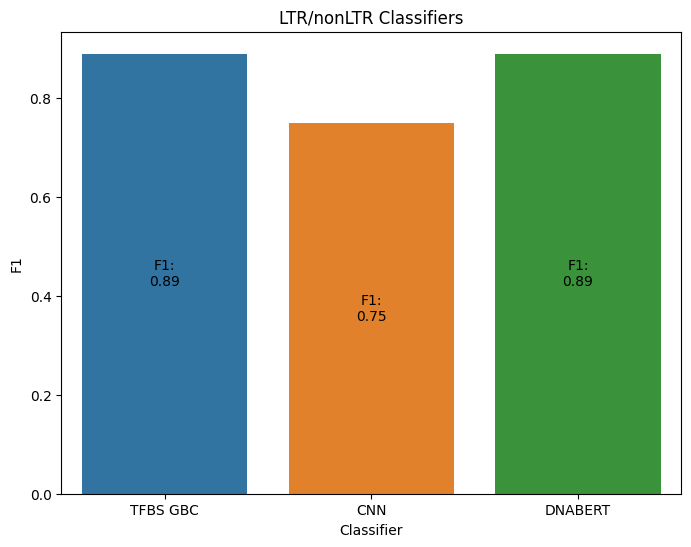

In [33]:
fig, ax = plt.subplots(figsize=(8, 6),dpi=100)

Superfam = pd.DataFrame({"F1": [0.89,0.75,0.89], "Classifier": ["TFBS GBC","CNN","DNABERT"]})
g = sns.barplot(x="Classifier", y="F1", data=Superfam, ax=ax)
g.set_title("LTR/nonLTR Classifiers")
ax.bar_label(ax.containers[-1], fmt='F1:\n%.2f', label_type='center')

## Load the models and move to GPU if available

In [47]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import pickle
# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('zhihan1996/DNA_bert_6')
model = BertForSequenceClassification.from_pretrained('xhorvat9/LTRBERT_superfamily_classifier_512', num_labels=2)

if torch.cuda.is_available():    

    device = torch.device("cuda")

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(4101, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

## Create necessary helper function with overloaded dataset class

In [6]:
import torch
import numpy as np
from transformers import BertTokenizer, BertModel

# write helper functions for tokenizing data
 # the kmer splitting function|
 
def Kmers_funct(seq, size=6):
   return [seq[x:x+size].upper() for x in range(len(seq) - size + 1)]
def tok_func(x): return " ".join(Kmers_funct(x.replace("N","")))


class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

## Load the sequences and draw predictions for sliding window using BERT

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import Bio.SeqIO as SeqIO
from sklearn.model_selection import train_test_split
import random

X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, random_state=42, test_size=0.15)

In [4]:
import pickle
model_embeddings = pickle.load(open("/var/tmp/xhorvat9/ltr_bert/NewClassifiers/LTR_classifier/BERT/LTRBERT_LTR_classifier_embeddings.b", "rb"))

## Train the CNN on BERT embeddings

In [7]:
import tensorflow as tf
import keras
import numpy as np
nn = keras.models.Sequential()
nn.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(768,1)))
nn.add(keras.layers.MaxPooling1D(pool_size=2))
nn.add(keras.layers.Flatten())
#nn.add(keras.layers.Dense(units=32, activation='relu'))
nn.add(keras.layers.Dense(units=1, activation='sigmoid'))

nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

nn.fit(X_train, np.array(y_train), epochs=4, batch_size=32, validation_split=0.1)

Epoch 1/5
982/982 [==============================] - 14s 14ms/step - loss: 0.3186 - accuracy: 0.8671 - val_loss: 0.3147 - val_accuracy: 0.8699
Epoch 2/5
982/982 [==============================] - 14s 15ms/step - loss: 0.3076 - accuracy: 0.8714 - val_loss: 0.3127 - val_accuracy: 0.8702
Epoch 3/5
982/982 [==============================] - 14s 14ms/step - loss: 0.3002 - accuracy: 0.8746 - val_loss: 0.3169 - val_accuracy: 0.8716
Epoch 4/5
982/982 [==============================] - 14s 14ms/step - loss: 0.2973 - accuracy: 0.8771 - val_loss: 0.3049 - val_accuracy: 0.8707
Epoch 5/5
982/982 [==============================] - 14s 15ms/step - loss: 0.2922 - accuracy: 0.8800 - val_loss: 0.3034 - val_accuracy: 0.8727


In [46]:
model

In [44]:
from sklearn.neural_network import MLPClassifier

MLP = MLPClassifier( verbose=True)
MLP.fit(X_train, y_train)

Iteration 1, loss = 0.32268063
Iteration 2, loss = 0.30490340
Iteration 3, loss = 0.29843012
Iteration 4, loss = 0.29923475
Iteration 5, loss = 0.29179535
Iteration 6, loss = 0.28999795
Iteration 7, loss = 0.28934541
Iteration 8, loss = 0.28636889
Iteration 9, loss = 0.28489291
Iteration 10, loss = 0.28185998
Iteration 11, loss = 0.28220361
Iteration 12, loss = 0.27805224
Iteration 13, loss = 0.27725415
Iteration 14, loss = 0.27768934
Iteration 15, loss = 0.27281635
Iteration 16, loss = 0.27155001
Iteration 17, loss = 0.27288187
Iteration 18, loss = 0.27000522
Iteration 19, loss = 0.26730919
Iteration 20, loss = 0.26669492
Iteration 21, loss = 0.26477961
Iteration 22, loss = 0.26536222
Iteration 23, loss = 0.26761846
Iteration 24, loss = 0.25993254
Iteration 25, loss = 0.26105740
Iteration 26, loss = 0.25896497
Iteration 27, loss = 0.25562330
Iteration 28, loss = 0.25545796
Iteration 29, loss = 0.25282765
Iteration 30, loss = 0.25328471
Iteration 31, loss = 0.25043633
Iteration 32, los

/var/tmp/xhorvat9/LTRBERT/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(verbose=True)

In [64]:
import torch
input_data = torch.Tensor(X_test)
input_data = input_data.to("cuda:0")
model.eval()
model.classifier.to("cuda:0")
with torch.no_grad():
    logits = model.classifier(input_data)

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define your model
model = Sequential()

# Add an input layer with 768 input features
model.add(Dense(64, activation='relu', input_dim=768))
model.add(Dropout(0.5))  # Add a dropout layer with a dropout rate of 0.5
# Add one or more hidden layers (you can experiment with the number of layers and units)
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))  # Add a dropout layer with a dropout rate of 0.3
# Add the output layer with 2 units for binary classification (softmax for multi-class)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# You can print the model summary to see the architecture
model.summary()
model.fit(X_train, np.array(y_train), epochs=6, batch_size=32, validation_split=0.1)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_67 (Dense)            (None, 64)                49216     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_68 (Dense)            (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_69 (Dense)            (None, 1)                 33        
                                                                 
Total params: 51,329
Trainable params: 51,329
Non-trainable params: 0


_________________________________________________________________
Epoch 1/6


/var/tmp/xhorvat9/LTRBERT/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


1192/1192 [==============================] - 2s 1ms/step - loss: 0.0000e+00 - accuracy: 0.2242 - val_loss: 0.0000e+00 - val_accuracy: 0.2219
Epoch 2/6
1192/1192 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 0.2219 - val_loss: 0.0000e+00 - val_accuracy: 0.2219
Epoch 3/6
1192/1192 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 0.2219 - val_loss: 0.0000e+00 - val_accuracy: 0.2219
Epoch 4/6
1192/1192 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 0.2219 - val_loss: 0.0000e+00 - val_accuracy: 0.2219
Epoch 5/6
1192/1192 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 0.2219 - val_loss: 0.0000e+00 - val_accuracy: 0.2219
Epoch 6/6
1192/1192 [==============================] - 1s 1ms/step - loss: 0.0000e+00 - accuracy: 0.2219 - val_loss: 0.0000e+00 - val_accuracy: 0.2219


In [34]:
X_train[0].shape

(768,)

In [3]:
import torch
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32 * 383, 1)  # Adjust the input size based on your data shape

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = torch.sigmoid(x)  # Sigmoid activation for binary classification
        return x

# Instantiate the model
model = CustomModel()

# Define the loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = torch.optim.Adam(model.parameters())

# Print the model architecture
print(model)


CustomModel(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=12256, out_features=1, bias=True)
)


In [9]:
from torch.utils.data import DataLoader, TensorDataset

train_data = TensorDataset( torch.tensor(X_train),  torch.tensor(y_train))
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# Make predictions
model.eval()
test_data = TensorDataset( torch.tensor(X_test),  torch.tensor(y_test))
with torch.no_grad():
    # Example input for prediction
    input_for_prediction = torch.Tensor(test_data) 
    prediction = model(input_for_prediction)

print("Prediction:", prediction.item())

RuntimeError: Expected 3-dimensional input for 3-dimensional weight [32, 1, 3], but got 2-dimensional input of size [32, 768] instead

In [ ]:

linear_nn = keras.models.Sequential()
linear_nn.add(keras.layers.Dense(512, activation='relu', input_shape=(768, 1)))
linear_nn.add(keras.layers.Dropout(0.5))
linear_nn.add(keras.layers.Dense(512, activation='relu', input_shape=(768, 1)))
linear_nn.add(keras.layers.Dense(units=1, activation='sigmoid', input_shape=(768, 1)))

linear_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

linear_nn.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.1)

In [22]:
import random
window_size = max_len
stride = max_len//3 # ~ 1/3 of window size
model.to(device)
outputs = []
sequences = []
for seq in X_test:
  seq_windows = []
  for i in range(0, len(seq), stride):
      start = i
      end = i + window_size

      if end > len(seq):
        end = len(seq)
      seq_windows.append(seq[start:end])
  sequences.append(seq_windows)

seq_ids = random.sample(range(len(sequences)), 3500)
sequences = [sequences[i] for i in seq_ids]
labels = [y_test[i] for i in seq_ids]
# Get the embeddings for the last layer and a specific token (e.g., the first token)
layer_index = -1  # Index of the last layer
token_index = 0   # Index of the token you're interested in
validation_embeddings = []
model.eval()
for s in tqdm.tqdm(sequences):
  tokenized_segment = tokenizer([tok_func(sequence_segment) for sequence_segment in s], padding=True, truncation=True, max_length=max_len, return_tensors="pt")
  tokenized_segment.to(device)
  with torch.no_grad():
      outputs = model(**tokenized_segment, output_hidden_states=True)
      hidden_states = outputs.hidden_states
      embeddings = hidden_states[layer_index][:, token_index, :]
      embeddings = embeddings.to('cpu')
      validation_embeddings.append(embeddings)

100%|██████████| 3500/3500 [01:46<00:00, 32.96it/s]


In [23]:
inp = []
for emb in tqdm.tqdm(validation_embeddings):
    inp.append((sum(emb)/len(emb)).numpy())
inp = np.array(inp)

100%|██████████| 3500/3500 [00:00<00:00, 44513.37it/s]


In [8]:
import numpy as np
nn.evaluate(X_test, np.array(y_test))

2187/2187 [==============================] - 3s 1ms/step - loss: 0.2096 - accuracy: 0.9146


[0.20959198474884033, 0.9145891666412354]

In [10]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.array(y_test), (nn.predict(X_test) > 0.5).astype(int).flatten())

2187/2187 [==============================] - 2s 911us/step


array([[24215,  3387],
       [ 2588, 39766]])

In [11]:
from sklearn.metrics import f1_score
f1_score(np.array(y_test), (nn.predict(X_test) > 0.5).astype(int).flatten())

2187/2187 [==============================] - 2s 918us/step


0.9301226800145018

### Run on test set

In [ ]:
window_size = 350
stride = 116 # ~ 1/3 of window size

outputs = []
sequences = []
for seq in X_test:
  seq_windows = []
  for i in range(0, len(seq), stride):
      start = i
      end = i + window_size

      if end > len(seq):
        end = len(seq)
      seq_windows.append(seq[start:end])
  sequences.append(seq_windows)

counter = 0
for s in sequences:
  if counter % 500 == 0 and counter != 0:
    print(f"processing sequence {counter}")
  X_test_tokenized = tokenizer([tok_func(x) for x in s], padding=True, truncation=True, max_length=350) # Create torch dataset
  test_dataset = Dataset(X_test_tokenized) # Load trained model
  test_trainer = Trainer(model) # Make prediction
  output, _,_ = test_trainer.predict(test_dataset) # Preprocess raw predictions
  outputs.append(output)

In [ ]:
i = tf.keras.preprocessing.sequence.pad_sequences(outputs, padding="pre", maxlen=45, dtype='float32')
score = nn.evaluate(i, y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.4219169020652771
Test accuracy: 0.8043588399887085


In [ ]:
nn.save('/content/drive/MyDrive/sequences/BERT_pooling_CNN/TF_CNN_BERT_pool_model')

### Visualize filters to check for influential regions


In [ ]:
import tensorflow as tf
new_model = tf.keras.models.load_model('/content/drive/MyDrive/sequences/BERT_pooling_CNN/TF_CNN_BERT_pool_model')

filters, biases = new_model.layers[0].get_weights()

In [ ]:
f = abs(filters)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, filters.shape[-1], figsize=(25, 10))
for i in range(filters.shape[-1]):
    im = axs[i].imshow(f[:, :, i], cmap="gray")
    axs[i].axis('off')
plt.show()